In [1]:
import requests
from scipy.stats import norm
import numpy as np
from datetime import datetime, timedelta,timezone
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm

# Data

In [2]:
#Lets read the historical_calls.csv file
df1 = pd.read_csv('historical_calls.csv')
df2 = pd.read_csv('historical_calls_2.csv')
df3 = pd.read_csv('historical_calls_3.csv')
df4 = pd.read_csv('test.csv')

In [3]:
#size of df2
print(df2.shape)
print(df1.shape)

(134861, 18)
(189210, 18)


In [4]:
#Lets merge the two dataframes
df = pd.concat([df1,df2])
df = pd.concat([df,df3])
df = pd.concat([df,df4])
#Lets remove duplicates rows
df = df.drop_duplicates()
print(df.shape)

(530424, 18)


When analyzing the implied volatility (IV) of an option, certain trades like combo trades, block trades, and liquidation events may indeed introduce distortions. Here's why each of these might not be ideal for IV analysis:

1. **Combo Trades**:
   - **Nature of Combo Trades**: These involve multiple positions executed simultaneously, often as part of complex strategies. The implied volatility derived from combo trades might not reflect the true market IV of a single option since the IV could be influenced by the combined risk and payoff structure of the strategy.
   - **Impact on IV Analysis**: Including combo trades can skew the IV analysis as these trades might reflect the overall strategy rather than the market's view on a single option's volatility.

2. **Block Trades**:
   - **Nature of Block Trades**: These large trades are often negotiated privately and may be executed at prices different from those prevailing in the public market. Block trades can reflect liquidity needs or strategic positions of large institutional investors rather than typical market conditions.
   - **Impact on IV Analysis**: Since block trades might not occur at market prices and can include a premium for liquidity, they might distort the actual implied volatility seen in the broader market.

3. **Liquidation Events**:
   - **Nature of Liquidation Events**: These occur when positions are forcibly closed, often during adverse market conditions or margin calls. Liquidation prices might be more reflective of urgent selling or buying pressures rather than balanced market sentiment.
   - **Impact on IV Analysis**: Implied volatility derived from liquidation trades can be anomalously high or low, as these trades are driven by necessity rather than a balanced view of market volatility.

### Best Practices for IV Analysis
To get a more accurate representation of the implied volatility, it is generally advisable to:

1. **Filter Out Specific Trades**: Exclude trades marked as combo trades, block trades, and liquidation events from your IV analysis to avoid distortions.
2. **Use Standard Trades**: Focus on standard buy and sell trades in the public order book, which more accurately reflect the market's consensus on volatility.
3. **Analyze Volume and Frequency**: Ensure that the trades you analyze are sufficiently frequent and of typical size to represent the market accurately.
4. **Check Market Conditions**: Be aware of overall market conditions during the period of your analysis, as extreme market conditions can also distort IV.


# Filters

In [5]:
#Lets filter out options where there is a value on combo_id block_trade_id, and liquidation
df = df[(df['combo_id'].isnull()) & (df['block_trade_id'].isnull()) & (df['liquidation'].isnull())]
df.shape

(522131, 18)

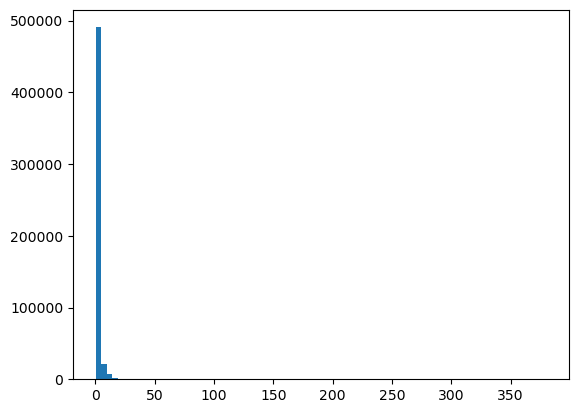

In [6]:
#Lets plot an hist of contracts and amount
plt.hist(df['amount'], bins=80)
plt.show()

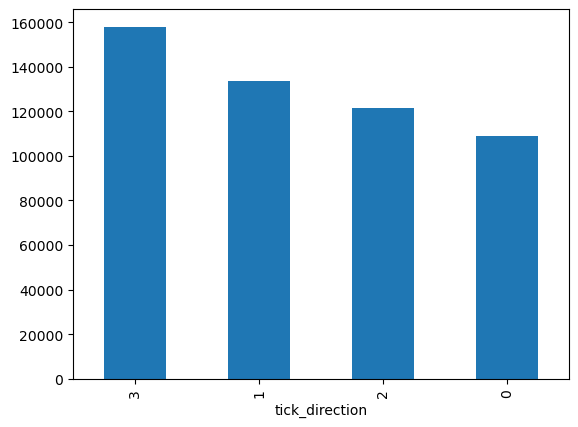

In [7]:
#Lets plot the tick_direction
df['tick_direction'].value_counts().plot(kind='bar')
plt.show()

The possible values for the `tick_direction` column are:

- **0**: Indicates that the trade price is equal to the previous trade price.
- **1**: Indicates an uptick, where the trade price is higher than the previous trade price.
- **2**: Indicates a downtick, where the trade price is lower than the previous trade price.
- **3**: Indicates a repeated tick, where the direction is the same as the previous tick.

These values provide information about the direction of the price change at the time of each trade. While useful for context, they may not directly impact IV analysis but can provide additional insights into market conditions.

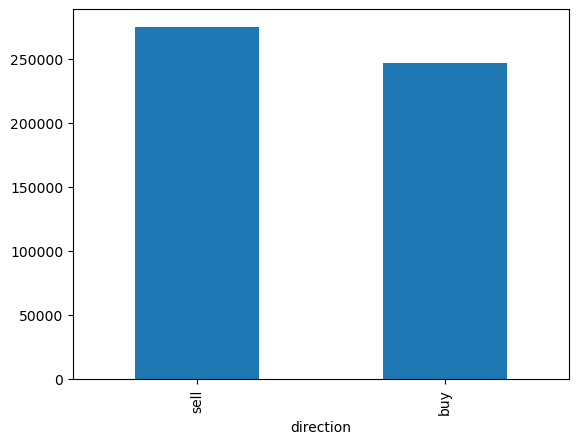

In [8]:
#Lets also plot the direction
df['direction'].value_counts().plot(kind='bar')
plt.show()

### Amount

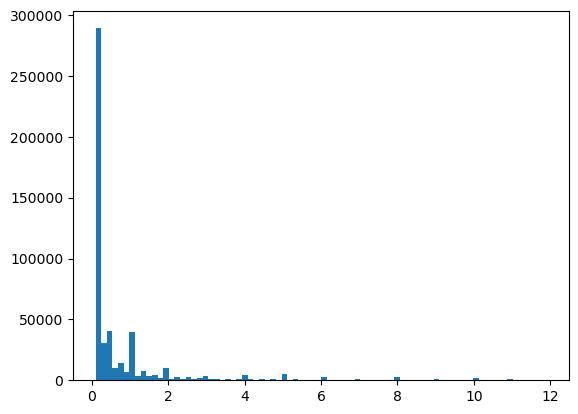

In [9]:
#Lets delete the rows with outliers quantity of contracts
df = df[df['amount'] < np.percentile(df['amount'], 99)]
plt.hist(df['amount'], bins=80)
plt.show()

While useful for understanding trade volume, extremely high or low contract numbers might reflect special conditions. Ensure average volume for better representation.

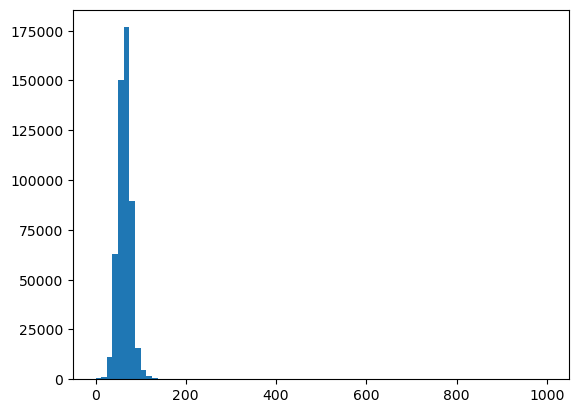

In [10]:
#Lets hist plot IV
plt.hist(df['iv'], bins=80)
plt.show()

### IV Filter

In [11]:
#Lets drop IV who is 0 or bigger than 300
df = df[(df['iv'] > 0) & (df['iv'] < 500)] #Maybe i should drop anything below 150 as its not normal

In [12]:
df.shape 

(515763, 18)

# New Variables

In [13]:
#Lets create a date column, with day, month and year
df.loc[:,'date'] = pd.to_datetime(df['timestamp'])
#Now we modify date so it is only day, month and year
df.loc[:,'date'] = df['date'].dt.date
#Now create time to maturity
df.loc[:,'time_to_maturity'] = pd.to_datetime(df['maturity']) - pd.to_datetime(df['timestamp'])
#Now we create days to maturity
df.loc[:,'days_to_maturity'] = df['time_to_maturity'].dt.days
#we also create minutes to maturity
df.loc[:,'minutes_to_maturity'] = df['time_to_maturity'].dt.seconds/60 + df['days_to_maturity']*24*60
#Lets create time to maturity as a fraction of a year
df.loc[:,'time_to_maturity_year'] = df['minutes_to_maturity']/(365*24*60)
#Lets correct strike price
df.loc[:,'strike'] = df['strike']*10


In [14]:
df_grouped = df.groupby(['date','instrument_name']).count()
#Lets reset the index
df_grouped = df_grouped.reset_index()
#Lets rename the column
df_grouped = df_grouped.rename(columns = {'timestamp':'trades_per_day'})
#Lets select the columns we want
df_grouped = df_grouped[['date','instrument_name','trades_per_day']]


## Top traded

<Axes: xlabel='instrument_name'>

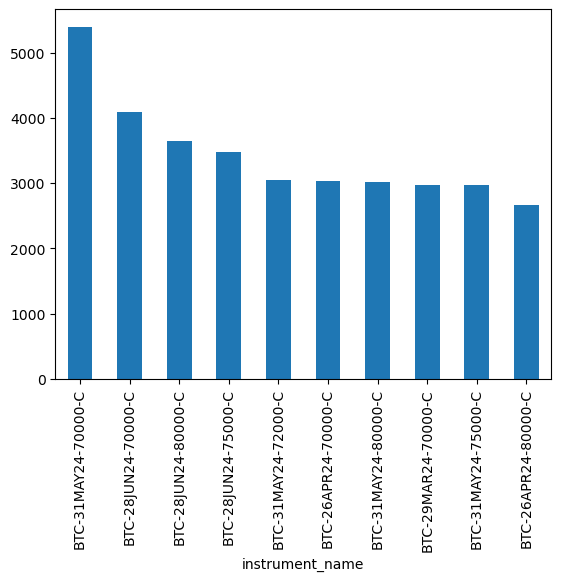

In [15]:
#Lets sum the trades_per_day by instrument_name

df_grouped_2 = df_grouped.groupby('instrument_name')['trades_per_day'].sum()
#Lets get the top 10 instruments
df_grouped_2 = df_grouped_2.sort_values(ascending=False)
df_grouped_2 = df_grouped_2.head(10)
#Lets plot the top 10 instruments
df_grouped_2.plot(kind='bar')

In [16]:
#Lets create a sub_df with the top 10 instruments, filtering df_grouped
sub_df = df_grouped[df_grouped['instrument_name'].isin(df_grouped_2.head(10).index)]

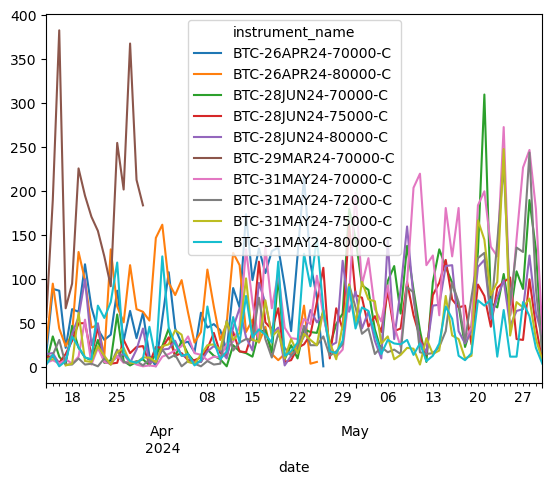

In [17]:
#Lets plot sub_df
sub_df = sub_df.pivot(index='date', columns='instrument_name', values='trades_per_day')
sub_df.plot(kind='line')
plt.show()

<Axes: xlabel='instrument_name'>

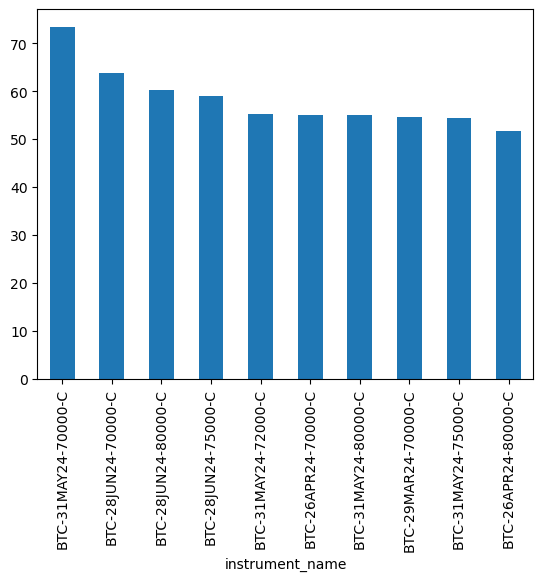

In [18]:
#Lets sum the trades_per_day by instrument_name

df_grouped_3 = df_grouped.groupby('instrument_name')['trades_per_day'].sum()
df_grouped_3 = np.sqrt(df_grouped_3)
#Lets get the top 10 instruments
df_grouped_3 = df_grouped_3.sort_values(ascending=False)
df_grouped_3 = df_grouped_3.head(10)
#Lets plot the top 10 instruments
df_grouped_3.plot(kind='bar')

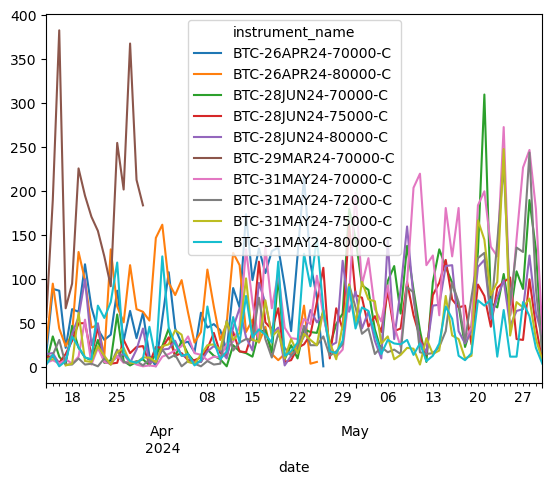

In [19]:
sub_df_2 = df_grouped[df_grouped['instrument_name'].isin(df_grouped_3.head(10).index)]
#plot
sub_df_2 = sub_df_2.pivot(index='date', columns='instrument_name', values='trades_per_day')
sub_df_2.plot(kind='line')
plt.show()

In [20]:
#Lets see wich instruments are in both df_grouped_2 and df_grouped_3
names = df_grouped_2.index.intersection(df_grouped_3.index)

In [21]:
#Lets create a sub sample of df with the instruments in names
df_sub = df[df['instrument_name'].isin(names)]


In [22]:
#Lets save to csv this sub sample
df_sub.to_csv('df_sub.csv', index=False)

In [23]:
#Lets now join the trades_per_day column to the original dataframe
df = pd.merge(df,df_grouped,how = 'left',on = ['date','instrument_name'])
df

,trade_seq,trade_id,timestamp,tick_direction,price,mark_price,iv,instrument_name,index_price,direction,...,combo_trade_id,combo_id,block_trade_id,liquidation,date,time_to_maturity,days_to_maturity,minutes_to_maturity,time_to_maturity_year,trades_per_day
0,77,302653023,2024-05-22 22:55:45.846,0,0.0065,0.005848,44.05,BTC-23MAY24-69000-C,69087.14,buy,...,NaN,NaN,NaN,NaN,2024-05-22,0 days 01:04:14.154000,0,64.233333,0.000122,13
1,44,302652721,2024-05-22 22:51:37.832,3,0.0090,0.009152,50.91,BTC-25MAY24-70500-C,69111.15,sell,...,NaN,NaN,NaN,NaN,2024-05-22,2 days 01:08:22.168000,2,2948.366667,0.005610,44
2,118,302652590,2024-05-22 22:50:45.047,2,0.0615,0.061738,50.51,BTC-7JUN24-67000-C,69092.15,sell,...,NaN,NaN,NaN,NaN,2024-05-22,15 days 01:09:14.953000,15,21669.233333,0.041228,4
3,43,302652427,2024-05-22 22:48:59.512,2,0.0090,0.009200,50.72,BTC-25MAY24-70500-C,69115.78,sell,...,NaN,NaN,NaN,NaN,2024-05-22,2 days 01:11:00.488000,2,2951.000000,0.005615,44
4,553,302652368,2024-05-22 22:48:00.644,2,0.0635,0.063600,65.90,BTC-27SEP24-95000-C,69124.00,buy,...,NaN,NaN,NaN,NaN,2024-05-22,127 days 01:11:59.356000,127,182951.983333,0.348082,27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515758,393,303530533,2024-05-30 06:05:25.779,2,0.0305,0.030391,52.62,BTC-28JUN24-74000-C,68014.54,sell,...,NaN,NaN,NaN,NaN,2024-05-30,28 days 17:54:34.221000,28,41394.566667,0.078757,18
515759,1041,303530439,2024-05-30 06:04:55.413,3,0.0001,0.000006,121.76,BTC-31MAY24-81000-C,68049.47,buy,...,NaN,NaN,NaN,NaN,2024-05-30,0 days 17:55:04.587000,0,1075.066667,0.002045,4
515760,30,303530382,2024-05-30 06:03:17.056,2,0.0037,0.003958,42.78,BTC-1JUN24-70000-C,68059.15,sell,...,NaN,NaN,NaN,NaN,2024-05-30,1 days 17:56:42.944000,1,2516.700000,0.004788,34
515761,41,303530348,2024-05-30 06:02:19.353,0,0.0055,0.005773,42.74,BTC-1JUN24-69500-C,68083.95,sell,...,NaN,NaN,NaN,NaN,2024-05-30,1 days 17:57:40.647000,1,2517.666667,0.004790,3


In [24]:
df_s = df.copy()

# New Variables 2

In [25]:
df = df_s.copy()
#Lets create the moneyness column
df.loc[:,'moneyness'] = df['index_price']/df['strike']
#Lets also create the hour of the day of the trade
df.loc[:,'hour'] = pd.to_datetime(df['timestamp']).dt.hour
#Lets also create the 7 days historical volatility of index_price
#If days_to_maturity is negative, we set it to 0
df.loc[:,'days_to_maturity'] = df['days_to_maturity'].apply(lambda x: max(0,x))
#Lets arrange df by timestamp

df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values('timestamp')
#Lets set timestamp as index
df = df.set_index('timestamp')
df.loc[:,'historical_volatility'] = df['index_price'].rolling('7D').std() / df['index_price'].rolling('7D').mean()
#Lets also calculate the 7 days moving average of the index_price
df.loc[:,'moving_average'] = df['index_price']/df['index_price'].rolling('7D').mean()
#Now we do  the same for 3 and 1 days
df.loc[:,'historical_volatility_3'] = df['index_price'].rolling('3D').std() / df['index_price'].rolling('3D').mean()
df.loc[:,'moving_average_3'] = df['index_price']/df['index_price'].rolling('3D').mean()
df.loc[:,'historical_volatility_1'] = df['index_price'].rolling('1D').std() / df['index_price'].rolling('1D').mean()
df.loc[:,'moving_average_1'] = df['index_price']/df['index_price'].rolling('1D').mean()

In [26]:
#Where are NAs in df[['price', 'mark_price', 'index_price', 'strike', 'days_to_maturity', 'moneyness', 'historical_volatility']]
df[['days_to_maturity', 'moneyness', 'historical_volatility','hour','moving_average','historical_volatility_3','moving_average_3','historical_volatility_1','moving_average_1']].isna().sum()

days_to_maturity           0
moneyness                  0
historical_volatility      1
hour                       0
moving_average             0
historical_volatility_3    1
moving_average_3           0
historical_volatility_1    1
moving_average_1           0
dtype: int64

In [27]:
df.head()

,trade_seq,trade_id,tick_direction,price,mark_price,iv,instrument_name,index_price,direction,contracts,...,time_to_maturity_year,trades_per_day,moneyness,hour,historical_volatility,moving_average,historical_volatility_3,moving_average_3,historical_volatility_1,moving_average_1
timestamp,,,,,,,,,,,,,,,,,,,,,
2024-03-14 04:00:08.049,767,290874608,1,0.0275,0.027113,81.56,BTC-26APR24-100000-C,73302.71,buy,0.1,...,0.117351,61,0.733027,4,NaN,1.000000,NaN,1.000000,NaN,1.000000
2024-03-14 04:00:13.870,768,290874613,1,0.0275,0.027118,81.55,BTC-26APR24-100000-C,73305.99,buy,0.1,...,0.117351,61,0.733060,4,0.000032,1.000022,0.000032,1.000022,0.000032,1.000022
2024-03-14 04:00:14.351,769,290874614,1,0.0275,0.027118,81.55,BTC-26APR24-100000-C,73305.99,buy,0.1,...,0.117351,61,0.733060,4,0.000026,1.000015,0.000026,1.000015,0.000026,1.000015
2024-03-14 04:02:04.053,2988,290874759,0,0.2895,0.289476,76.94,BTC-28JUN24-60000-C,73297.40,buy,0.1,...,0.289950,2,1.221623,4,0.000055,0.999923,0.000055,0.999923,0.000055,0.999923
2024-03-14 04:03:28.288,280,290874890,0,0.0016,0.001489,56.83,BTC-14MAR24-74000-C,73326.11,buy,0.2,...,-0.000463,80,0.990893,4,0.000149,1.000252,0.000149,1.000252,0.000149,1.000252


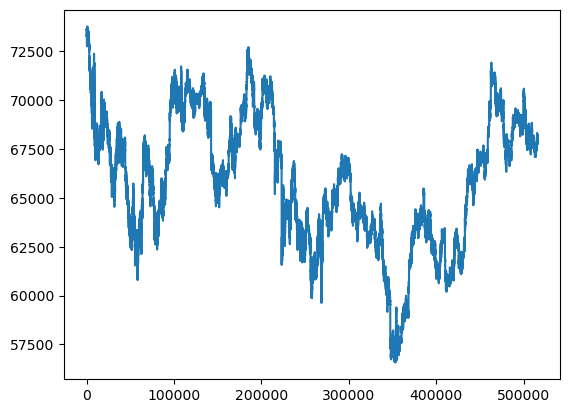

In [90]:
#Lets plot all the index_price
df['index_price'].plot()
plt.show()

## Instruments with maturity on data

In [97]:
df = df.reset_index()
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['maturity'] = pd.to_datetime(df['maturity'])

# Find the first and last available dates in the data
first_date = df['timestamp'].min() 
#Lets add 2 days to first_date
first_date = first_date + timedelta(days=2)
last_date = df['timestamp'].max()

# Filter instruments whose maturity date is before the last date and start date is after the first date
filtered_instruments = df[(df['maturity'] < last_date) & (df['timestamp'] > first_date)]

# Count the number of trades for each instrument
trade_counts = filtered_instruments['instrument_name'].value_counts()

# Rank the instruments by the number of trades
ranked_instruments = trade_counts.reset_index()
ranked_instruments.columns = ['instrument_name', 'trade_count']
ranked_instruments = ranked_instruments.sort_values(by='trade_count', ascending=False)

# Display the ranked instruments
print(ranked_instruments.head(15))


        instrument_name  trade_count
0   BTC-26APR24-70000-C         2892
1   BTC-29MAR24-70000-C         2655
2   BTC-26APR24-80000-C         2544
3   BTC-24MAY24-70000-C         2302
4   BTC-26APR24-65000-C         2297
5   BTC-26APR24-75000-C         2238
6   BTC-26APR24-71000-C         2066
7   BTC-17MAY24-65000-C         2030
8   BTC-26APR24-69000-C         1972
9   BTC-26APR24-67000-C         1927
10  BTC-26APR24-68000-C         1919
11  BTC-29MAR24-71000-C         1893
12  BTC-26APR24-66000-C         1796
13  BTC-10MAY24-64000-C         1776
14  BTC-26APR24-72000-C         1766


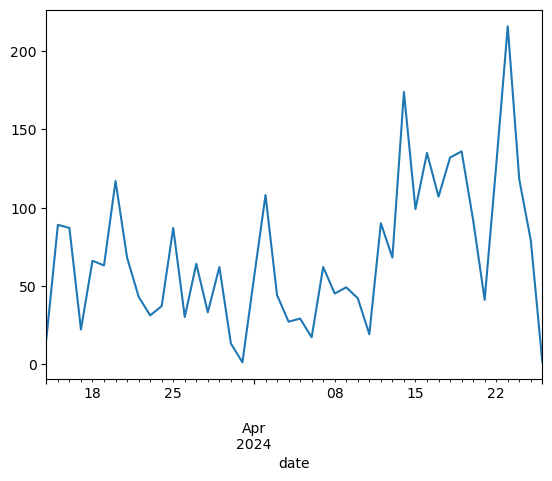

In [29]:
#Lets plot the number of trades per day of BTC-24MAY24-70000-C
#df sorter by date
#df = df.sort_values('date')
df_btc = df[df['instrument_name'] == 'BTC-26APR24-70000-C']
df_btc = df_btc.groupby('date')['instrument_name'].count()
#The x axis is the date
df_btc.plot(kind='line')

plt.show()

In [30]:
#Lets get the strike price and maturity of BTC-26APR24-70000-C
df_btc = df[df['instrument_name'] == 'BTC-26APR24-70000-C']
df_btc = df_btc[['strike','maturity']]
df_btc = df_btc.drop_duplicates()
df_btc


,strike,maturity
3219,70000.0,2024-04-26


In [31]:
#Lets drop where rows of mark_price and historical_volatility are NAs
df = df.dropna(subset=['historical_volatility','historical_volatility_1'])

In [32]:
df.head()

,timestamp,trade_seq,trade_id,tick_direction,price,mark_price,iv,instrument_name,index_price,direction,...,time_to_maturity_year,trades_per_day,moneyness,hour,historical_volatility,moving_average,historical_volatility_3,moving_average_3,historical_volatility_1,moving_average_1
1,2024-03-14 04:00:13.870,768,290874613,1,0.0275,0.027118,81.55,BTC-26APR24-100000-C,73305.99,buy,...,0.117351,61,0.733060,4,0.000032,1.000022,0.000032,1.000022,0.000032,1.000022
2,2024-03-14 04:00:14.351,769,290874614,1,0.0275,0.027118,81.55,BTC-26APR24-100000-C,73305.99,buy,...,0.117351,61,0.733060,4,0.000026,1.000015,0.000026,1.000015,0.000026,1.000015
3,2024-03-14 04:02:04.053,2988,290874759,0,0.2895,0.289476,76.94,BTC-28JUN24-60000-C,73297.40,buy,...,0.289950,2,1.221623,4,0.000055,0.999923,0.000055,0.999923,0.000055,0.999923
4,2024-03-14 04:03:28.288,280,290874890,0,0.0016,0.001489,56.83,BTC-14MAR24-74000-C,73326.11,buy,...,-0.000463,80,0.990893,4,0.000149,1.000252,0.000149,1.000252,0.000149,1.000252
5,2024-03-14 04:03:28.290,281,290874891,0,0.0017,0.001489,58.37,BTC-14MAR24-74000-C,73326.11,sell,...,-0.000463,80,0.990893,4,0.000168,1.000210,0.000168,1.000210,0.000168,1.000210


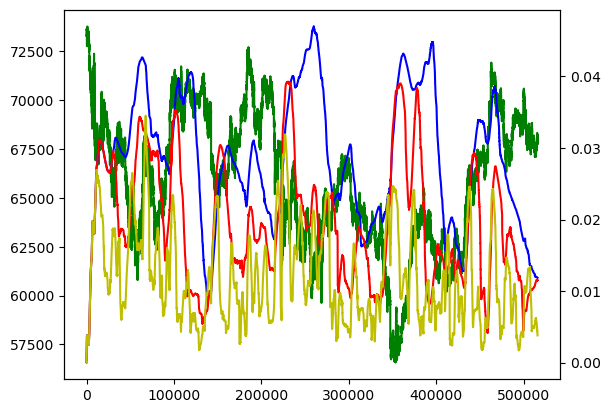

In [33]:
#Lets  plot the index_price and the historical_volatility, of 1, 3 and 7 days
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(df['index_price'], 'g-')
ax2.plot(df['historical_volatility'], 'b-')
ax2.plot(df['historical_volatility_3'], 'r-')
ax2.plot(df['historical_volatility_1'], 'y-')

plt.show()


In [143]:
#Model for Implied Volatility
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Select relevant features and target variable
features = df[['days_to_maturity', 'moneyness', 'historical_volatility','hour','moving_average','moving_average_3','moving_average_1','historical_volatility_3','historical_volatility_1']]
target = df['iv']

# Split data into training and testing sets
#Lets do it with cross validation

#Lets do a windows rolling cross validation

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Train the model
model = RandomForestRegressor()
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')


Mean Squared Error: 5.891577421701442


In [144]:
#Lets save the model 
import joblib
joblib.dump(model, 'model.pkl')


['model.pkl']

In [34]:
#Lets load the model
import joblib
model = joblib.load('model.pkl')

                   Feature  Importance
1                moneyness    0.296217
0         days_to_maturity    0.148286
4           moving_average    0.145865
2    historical_volatility    0.133183
7  historical_volatility_3    0.113603
8  historical_volatility_1    0.067433
5         moving_average_3    0.038538
6         moving_average_1    0.031450
3                     hour    0.025426


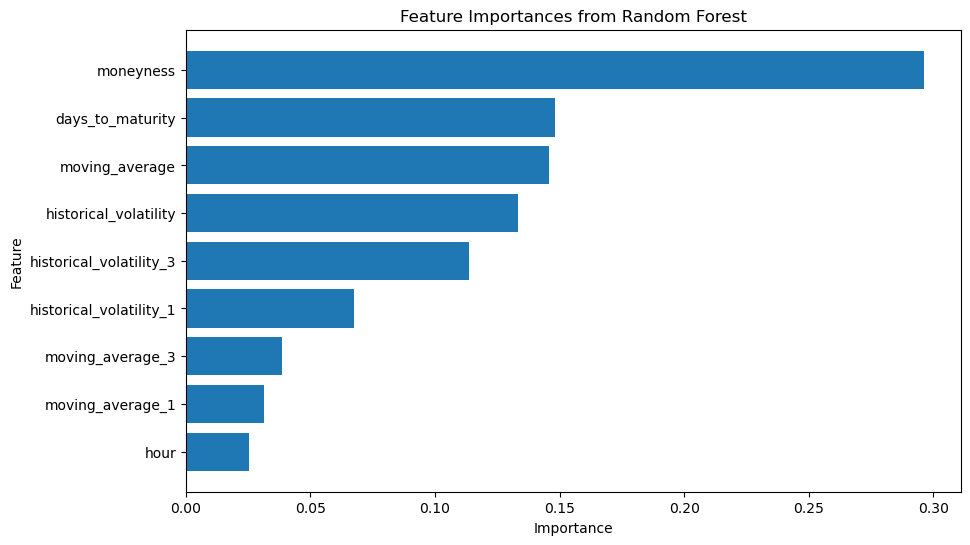

In [35]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
features = df[['days_to_maturity', 'moneyness', 'historical_volatility','hour','moving_average','moving_average_3','moving_average_1','historical_volatility_3','historical_volatility_1']]
# Get feature importances
importances = model.feature_importances_
feature_names = features.columns

# Create a DataFrame for easy visualization
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Print the top predictors
print(importance_df)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances from Random Forest')
plt.gca().invert_yaxis()
plt.show()


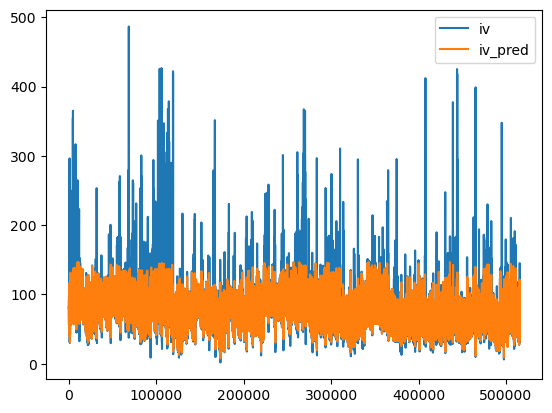

In [36]:
#Lets take out the index and sort by timestamp
#df = df.reset_index()
#df = df.sort_values('timestamp')
#Lets predict and plot the IV
features = df[['days_to_maturity', 'moneyness', 'historical_volatility','hour','moving_average','moving_average_3','moving_average_1','historical_volatility_3','historical_volatility_1']]

df.loc[:,'iv_pred'] = model.predict(features)
df[['iv', 'iv_pred']].plot(kind='line')
plt.show()

In [39]:
#Lets do a matrix plot for the freatures
#pd.plotting.scatter_matrix(features, figsize=(12, 12))
#plt.show()

In [40]:
#Lets now read the test csv
#test = pd.read_csv('test.csv')

In [41]:
#Lets keep unique
#test = test.drop_duplicates()
#test.shape

In [42]:
#Lets first filter test
#test = test[(test['combo_id'].isnull()) & (test['block_trade_id'].isnull()) & (test['liquidation'].isnull())]
#test = test[(test['iv'] > 0) & (test['iv'] < 300)]
#test = test[test['amount'] < np.percentile(test['amount'], 99)]

In [43]:

# test = test.reset_index()
# test.loc[:,'strike'] = test['strike']*10
# test.loc[:,'moneyness'] = test['index_price']/test['strike']
# test.loc[:,'hour'] = pd.to_datetime(test['timestamp']).dt.hour
# test.loc[:,'days_to_maturity'] = pd.to_datetime(test['maturity']) - pd.to_datetime(test['timestamp'])
# test.loc[:,'days_to_maturity'] = test['days_to_maturity'].dt.days
# #If days to maturity is negative, we set it to 0
# test.loc[:,'days_to_maturity'] = test['days_to_maturity'].apply(lambda x: max(0,x))
# test.loc[:,'minutes_to_maturity'] = test['days_to_maturity']*24*60
# test.loc[:,'time_to_maturity_year'] = test['minutes_to_maturity']/(365*24*60)
# #Lets create date
# test.loc[:,'date'] = pd.to_datetime(test['timestamp']).dt.date
# test['timestamp'] = pd.to_datetime(test['timestamp'])

In [44]:
# #Lets plot date
# test['date'].value_counts().plot(kind='bar')
# plt.show()

In [45]:
# #Lets now test the model 
# test.loc[:,'date'] = pd.to_datetime(test['date'])
# test = test.sort_values('timestamp')
# test = test.set_index('date')
# test.loc[:,'historical_volatility'] = test['index_price'].rolling('7D').std() / test['index_price'].rolling('7D').mean()
# test.loc[:,'moving_average'] = test['index_price']/test['index_price'].rolling('7D').mean()
# test.loc[:,'historical_volatility_3'] = test['index_price'].rolling('3D').std() / test['index_price'].rolling('3D').mean()
# test.loc[:,'moving_average_3'] = test['index_price']/test['index_price'].rolling('3D').mean()
# test.loc[:,'historical_volatility_1'] = test['index_price'].rolling('1D').std() / test['index_price'].rolling('1D').mean()
# test.loc[:,'moving_average_1'] = test['index_price']/test['index_price'].rolling('1D').mean()
# test = test.dropna(subset=['historical_volatility','historical_volatility_1'])

In [46]:
# #Lets now test the model
# test.loc[:,'iv_pred'] = model.predict(test[['days_to_maturity', 'moneyness', 'historical_volatility','hour','moving_average','moving_average_3','moving_average_1','historical_volatility_3','historical_volatility_1']])
# test = test.reset_index()
# test[['iv', 'iv_pred']].plot(kind='line',alpha=0.5)
# plt.show()

In [47]:
# #Lets get the mean squared error
# mse = mean_squared_error(test['iv'], test['iv_pred'])
# print(f'Mean Squared Error: {mse}')

### Purpose
The Black-Scholes formula aims to provide a theoretical estimate of the price of European put and call options, excluding the effects of dividends paid during the option's life. It is based on the assumption that markets are efficient, which means that the option prices are predicted as if they have been corrected to reflect all known information.

### The Formula
The price of a call option (C) can be calculated using the formula:

\[ $C = S_0 \cdot N(d_1) - K \cdot e^{-rT} \cdot N(d_2)$ \]

where:
- \( S_0 \) is the current stock price
- \( K \) is the strike price of the option
- \( T \) is the time to expiration
- \( r \) is the risk-free rate
- \( N(d) \) is the cumulative distribution function of the standard normal distribution
- \( d_1 \) and \( d_2 \) are calculated as follows:
- \[ d_1 = $ \frac{\ln(\frac{S_0}{K}) + (r + \frac{\sigma^2}{2})T}{\sigma \sqrt{T}}] $
- \[ d_2 = $d_1 - \sigma \sqrt{T} $]
- \( $\sigma$ \) is the volatility of the stock's returns


- \($N(d_1)$\) and \($N(d_2)$\) are probabilities derived from the standard normal distribution, which help in calculating the expected benefit from owning the stock and the expected cost of exercising the option, respectively.
- \(N(d_1)\) gives the probability that the option will be in the money (profitable to exercise) by the expiration date, adjusted for the risk-free rate and the time remaining until expiration.
- \(N(d_2)\) adjusts this probability by the volatility of the stock, accounting for the likelihood that the stock's price will exceed the strike price at expiration.


### Key Assumptions
The Black-Scholes model is based on several critical assumptions:
1. **Stock prices follow a log-normal distribution** because of continuous compounding.
2. **No dividends are paid out** during the life of the option.
3. **Markets are efficient**, meaning that prices reflect all known information.
4. **No commissions** are charged in the buying or selling of the option.
5. **Interest rates remain constant and known** over the option's life.
6. **Volatility is constant** over the option's life.

### Limitations
While the Black-Scholes formula is pioneering and widely used, it has limitations:
- It does not consider the payment of dividends.
- It assumes volatility and interest rates are constant, which might not hold in real-world scenarios.
- The log-normal distribution of stock prices may not accurately describe actual stock price movements, especially those exhibiting jumps or fat tails.



## Deribit FEES
Options Trading:
- **Taker Fee**: 0.03% of the underlying asset.
- **Maker Fee**: 0.03% of the underlying asset.
- **Exercise Fee**: 0.015% of the underlying asset per contract.

In [37]:
import pandas as pd
import numpy as np
from scipy.stats import norm

# Define Black-Scholes delta calculation for a call option
def call_delta(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    return norm.cdf(d1)


In [38]:

# Define Black-Scholes call option price
def black_scholes_call(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)


In [47]:

# Delta hedging function with transaction costs
def synthetic_delta_hedging(df, forecast_iv_column, initial_stock_price, r=0.01, trading_fee_rate=0.002, network_fee=0.0003):
    # Initialize portfolio and stock positions
    portfolio_value = 0
    cash_position = initial_stock_price  # Starting with cash equal to initial stock price
    stock_position = 0  # Starting with 1 stock
    
    results = []

    for index, row in df.iterrows():
        S = row['index_price']
        K = row['strike']
        T = row['days_to_maturity'] / 365  # Convert days to years
        date = row['date']
       
        sigma_actual = row['iv'] / 100  # Convert percentage to decimal
        if forecast_iv_column != 0:
            sigma_forecast = row[forecast_iv_column] / 100  # Convert percentage to decimal
        else:
            sigma_forecast = sigma_actual
        # Calculate forecasted delta
        delta_forecast = (call_delta(S, K, T, r, sigma_forecast))*(-1) #is negative because we are shorting the call
        
        # Calculate the number of stocks to buy/sell to adjust to the new delta
        delta_change = delta_forecast - stock_position
        transaction_cost = 0
        
        if delta_change != 0:
            # Calculate transaction cost: trading fee + network fee
            trading_fee = abs(delta_change) * S * trading_fee_rate
            #transaction_cost = trading_fee + network_fee*S
            transaction_cost = 0
            
            if abs(delta_change * S) > transaction_cost:
                # Update cash position considering transaction cost
                cash_position -= transaction_cost #we substract the transaction cost from the cash position
                
                # Adjust stock position to maintain delta neutrality
                cash_position += delta_change * S #if delta_change is positive, we are buying stock, if negative we are selling stock.
                #If we buy stock, we substract the stock price from the cash position
                stock_position = delta_forecast #we set the stock position to the forecasted delta
                
        
        # Calculate actual option price using Black-Scholes
        #option_price_actual = black_scholes_call(S, K, T, r, sigma_actual)
        
        # Update portfolio value
        portfolio_value = (stock_position * S*(-1)) + cash_position #portfolio value is the stock position times the stock price plus the cash position
        
        # Store results
        results.append({
            'timestamp': index,
            'date': date,
            'index_price': S,
            'strike': K,
            'days_to_maturity': row['days_to_maturity'],
            'forecast_iv': sigma_forecast,
            'actual_iv': sigma_actual,
            'forecast_delta': delta_forecast,
            'delta_change': delta_change,
            'transaction_cost': transaction_cost,
            'portfolio_value': portfolio_value,
            'stock_position': stock_position,
        })
    
    return pd.DataFrame(results)

# Example usage (Do not execute this block, it's just an example)
# df_doge['predicted_iv'] = iv_predictions  # Assuming iv_predictions is obtained from the model
# results = delta_hedging(df_doge, 'predicted_iv', initial_stock_price=100)
# print(results.head())


Espacio


In [48]:
#Having df now we calculate the delta of the option
#Lets calculate the delta of the option
def delta(S,K,T,r,sigma,option_type):
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T)/(sigma*np.sqrt(T))
    if option_type == 'call':
        delta = norm.cdf(d1)
    elif option_type == 'put':
        delta = norm.cdf(d1) - 1
    return delta

In [49]:
#Lets get the delta
#df['delta'] = df.apply(lambda x: delta(x['index_price'],x['strike'],x['time_to_maturity_year'],0,x['iv']/100,'call'),axis = 1)

In [107]:
#Lets create a data with only BTC-26APR24-70000-C
df_btc_2 = df[df['instrument_name'] == 'BTC-26APR24-70000-C']
#Lets get the first date
first_date = df_btc_2['timestamp'].min()

In [51]:
#Lets do delta hedging with df_btc_2
#Lets calculate the initial_stock_price as the delta of the first row
#initial_stock_price = df_btc_2['index_price'].iloc[0]
results = synthetic_delta_hedging(df_btc_2, 0, initial_stock_price=0)

/var/folders/tp/zh64fv6d1lx6rq42d6ymqtqw0000gn/T/ipykernel_13811/850695703.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))


In [131]:
results.tail()

,timestamp,date,index_price,strike,days_to_maturity,forecast_iv,actual_iv,forecast_delta,delta_change,transaction_cost,portfolio_value,stock_position
3036,310240,2024-04-25,63463.67,70000.0,0,0.9041,0.9041,-0.0,0.0,0,-7049.376573,-0.0
3037,310651,2024-04-25,64103.19,70000.0,0,0.8542,0.8542,-0.0,0.0,0,-7049.376573,-0.0
3038,310653,2024-04-25,64096.55,70000.0,0,0.8547,0.8547,-0.0,0.0,0,-7049.376573,-0.0
3039,311250,2024-04-25,64478.96,70000.0,0,0.9209,0.9209,-0.0,0.0,0,-7049.376573,-0.0
3040,313374,2024-04-26,64538.66,70000.0,0,1.4307,1.4307,-0.0,0.0,0,-7049.376573,-0.0


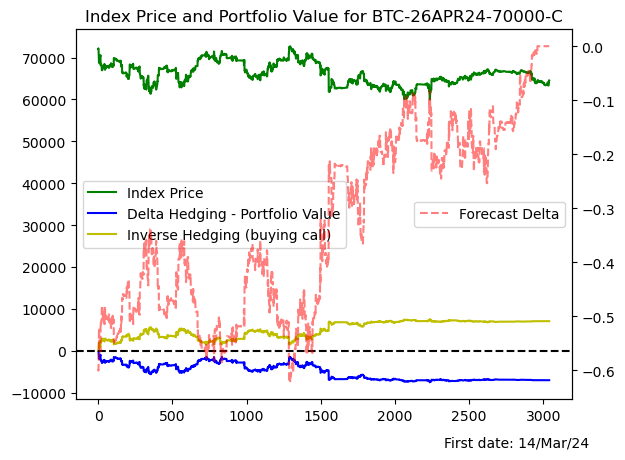

In [119]:
#Lets plo the index_price and portfolio_value
#on other index we plot the delta
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(results['index_price'], 'g-')
ax1.plot(results['portfolio_value'], 'b-')
ax1.plot(results['portfolio_value']*-1, 'y-')
#Lets put a line at 0
ax1.axhline(y=0, color='black', linestyle='--')
#We also add the stock position
ax2.plot(results['forecast_delta'], 'r--', alpha=0.5)
#lets add a title
plt.title('Index Price and Portfolio Value for BTC-26APR24-70000-C')
#add the legend
ax1.legend(['Index Price', 'Delta Hedging - Portfolio Value','Inverse Hedging (buying call)'],loc = 'center left')
#Lets position the legend of the delta
ax2.legend(['Forecast Delta'],loc = 'center right')
#Lets add a note at foot with the first date at format DD/BBB/YY like First date: 01/Jan/21
plt.figtext(0.7, 0.01, 'First date: ' + first_date.strftime('%d/%b/%y'))
plt.show()

In [80]:
#Lets get the last portfolio value
last_portfolio_value = results['portfolio_value'].iloc[-1]
print(f'Last Portfolio Value: {last_portfolio_value}')
#Lets also print the initial option value by black scholes
initial_option_value = black_scholes_call(df_btc_2['index_price'].iloc[0],df_btc_2['strike'].iloc[0],df_btc_2['time_to_maturity_year'].iloc[0],0,df_btc_2['iv'].iloc[0]/100)
print(f'Initial Option Value: {initial_option_value}')
print(f'Inverse Hedging (buying call): {results["portfolio_value"].iloc[-1]*-1}')

Last Portfolio Value: -7049.376572553376
Initial Option Value: 8122.854696697264
Inverse Hedging (buying call): 7049.376572553376


In [135]:
#We now do the same with forecasted iv
results_2 = synthetic_delta_hedging(df_btc_2, 'iv_pred', initial_stock_price=0)

/var/folders/tp/zh64fv6d1lx6rq42d6ymqtqw0000gn/T/ipykernel_13811/850695703.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))


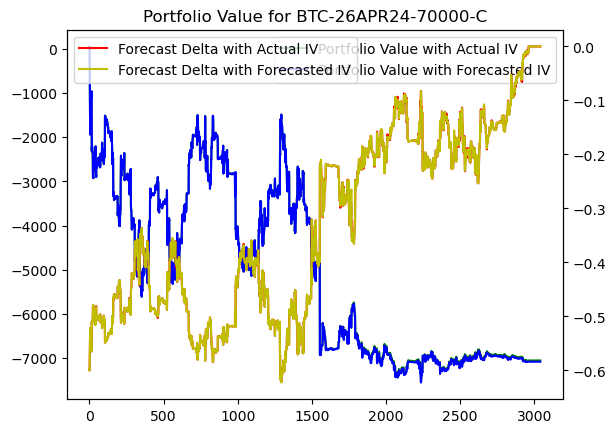

In [136]:
#We compare the porfolio value of the two results and plot it
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(results['portfolio_value'], 'g-')
ax1.plot(results_2['portfolio_value'], 'b-')
#We also add the stock position
ax2.plot(results['forecast_delta'], 'r-')
ax2.plot(results_2['forecast_delta'], 'y-')
#lets add a title
plt.title('Portfolio Value for BTC-26APR24-70000-C')
#add the legend
ax1.legend(['Portfolio Value with Actual IV', 'Portfolio Value with Forecasted IV'])
ax2.legend(['Forecast Delta with Actual IV','Forecast Delta with Forecasted IV'])
plt.show()

In [64]:
#We create a dataframe with date and the average of index_price, and also its std
results_2

,timestamp,date,index_price,strike,days_to_maturity,forecast_iv,actual_iv,forecast_delta,delta_change,transaction_cost,portfolio_value,stock_position
0,3219,2024-03-14,72113.53,70000.0,42,0.727805,0.7278,-0.598161,-0.598161,86.271326,-86.271326,-0.598161
1,3221,2024-03-14,72204.99,70000.0,42,0.727693,0.7272,-0.600146,-0.001985,0.286945,-141.266091,-0.600146
2,3686,2024-03-14,71768.75,70000.0,42,0.740059,0.7404,-0.590762,0.009384,1.347254,119.194390,-0.590762
3,4896,2024-03-14,70617.81,70000.0,42,0.731396,0.7331,-0.565176,0.025586,3.613922,795.512214,-0.565176
4,5932,2024-03-14,69407.06,70000.0,42,0.729913,0.7376,-0.537481,0.027695,3.844756,1475.954716,-0.537481
...,...,...,...,...,...,...,...,...,...,...,...,...
3036,310240,2024-04-25,63463.67,70000.0,0,0.917370,0.9041,-0.000000,0.000000,0.000000,5233.429976,-0.000000
3037,310651,2024-04-25,64103.19,70000.0,0,0.860856,0.8542,-0.000000,0.000000,0.000000,5233.429976,-0.000000
3038,310653,2024-04-25,64096.55,70000.0,0,0.859176,0.8547,-0.000000,0.000000,0.000000,5233.429976,-0.000000
3039,311250,2024-04-25,64478.96,70000.0,0,0.900346,0.9209,-0.000000,0.000000,0.000000,5233.429976,-0.000000


- "Moneyness" is a term used in options trading to describe the relationship between the strike price of an option and the current market price of the underlying asset. (in the money, at the money and out of the money)

Executing a rolling window simulation to evaluate the performance of a dynamic hedging strategy using options over a specified time period (from January 1, 2022, to January 1, 2023). It calculates the total returns from the hedging strategy and the option payoff at the end of each period. 

In [121]:
#LEts try everything for BTC-26APR24-65000-C
df_btc_3 = df[df['instrument_name'] == 'BTC-26APR24-65000-C']
#lets get first date
first_date_2 = df_btc_3['timestamp'].min()

In [133]:
df['timestamp'].min()

Timestamp('2024-03-14 04:00:13.870000')

In [87]:
results_3 = synthetic_delta_hedging(df_btc_3, 0, initial_stock_price=0)
results_3

/var/folders/tp/zh64fv6d1lx6rq42d6ymqtqw0000gn/T/ipykernel_13811/850695703.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))


,timestamp,date,index_price,strike,days_to_maturity,forecast_iv,actual_iv,forecast_delta,delta_change,transaction_cost,portfolio_value,stock_position
0,4164,2024-03-14,70723.67,65000.0,42,0.7315,0.7315,-0.680398,-0.680398,0,0.000000,-0.680398
1,4315,2024-03-14,70667.27,65000.0,42,0.7322,0.7322,-0.679174,0.001224,0,-38.374445,-0.679174
2,4316,2024-03-14,70622.00,65000.0,42,0.7349,0.7349,-0.677968,0.001206,0,-69.120632,-0.677968
3,4317,2024-03-14,70622.00,65000.0,42,0.7349,0.7349,-0.677968,0.000000,0,-69.120632,-0.677968
4,4318,2024-03-14,70622.00,65000.0,42,0.7349,0.7349,-0.677968,0.000000,0,-69.120632,-0.677968
...,...,...,...,...,...,...,...,...,...,...,...,...
2453,314222,2024-04-26,64360.03,65000.0,0,0.5879,0.5879,-0.000000,0.000000,0,-8314.896748,-0.000000
2454,314290,2024-04-26,64575.12,65000.0,0,0.5393,0.5393,-0.000000,0.000000,0,-8314.896748,-0.000000
2455,314291,2024-04-26,64575.12,65000.0,0,0.5343,0.5343,-0.000000,0.000000,0,-8314.896748,-0.000000
2456,314292,2024-04-26,64575.12,65000.0,0,0.5343,0.5343,-0.000000,0.000000,0,-8314.896748,-0.000000


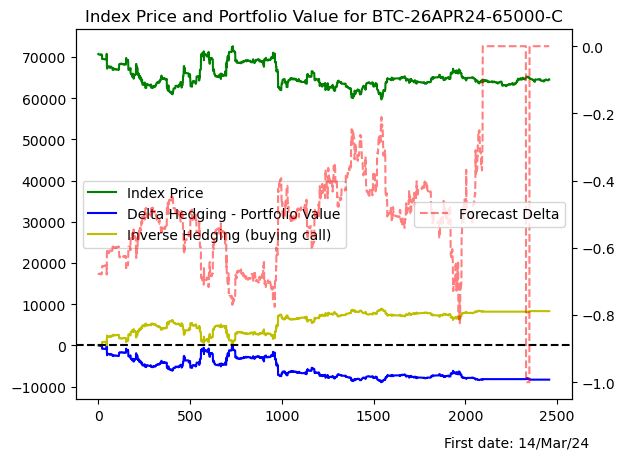

In [122]:
#lets plot
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(results_3['index_price'], 'g-')
ax1.plot(results_3['portfolio_value'], 'b-')
ax1.plot(results_3['portfolio_value']*-1, 'y-')
#Lets put a line at 0
ax1.axhline(y=0, color='black', linestyle='--')
#We also add the stock position
ax2.plot(results_3['forecast_delta'], 'r--', alpha=0.5)
#lets add a title
plt.title('Index Price and Portfolio Value for BTC-26APR24-65000-C')
#add the legend
ax1.legend(['Index Price', 'Delta Hedging - Portfolio Value','Inverse Hedging (buying call)'],loc = 'center left')
#Lets position the legend of the delta
ax2.legend(['Forecast Delta'],loc = 'center right')
#Lets add a note at foot with the first date at format DD/BBB/YY like First date: 01/Jan/21
plt.figtext(0.7, 0.01, 'First date: ' + first_date_2.strftime('%d/%b/%y'))
plt.show()


In [88]:
#lets print
last_portfolio_value = results_3['portfolio_value'].iloc[-1]
print(f'Last Portfolio Value: {last_portfolio_value}')
#Lets also print the initial option value by black scholes
#print the initial option value
initial_option_value = black_scholes_call(df_btc_3['index_price'].iloc[0],df_btc_3['strike'].iloc[0],df_btc_3['time_to_maturity_year'].iloc[0],0,df_btc_3['iv'].iloc[0]/100)
print(f'Initial Option Value: {initial_option_value}')
print(f'Inverse Hedging (buying call): {results_3["portfolio_value"].iloc[-1]*-1}')

Last Portfolio Value: -8314.896748475505
Initial Option Value: 9970.444588782128
Inverse Hedging (buying call): 8314.896748475505


In [123]:
#Lets do the same for BTC-17MAY24-65000-C
df_btc_4 = df[df['instrument_name'] == 'BTC-17MAY24-65000-C']
results_4 = synthetic_delta_hedging(df_btc_4, 0, initial_stock_price=0)
#lets get first date
first_date_3 = df_btc_4['timestamp'].min()

/var/folders/tp/zh64fv6d1lx6rq42d6ymqtqw0000gn/T/ipykernel_13811/850695703.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))


In [95]:
results_4.tail()

,timestamp,date,index_price,strike,days_to_maturity,forecast_iv,actual_iv,forecast_delta,delta_change,transaction_cost,portfolio_value,stock_position
2025,444240,2024-05-17,66322.38,65000.0,0,1.2292,1.2292,-1.0,0.0,0,-1434.703702,-1.0
2026,444241,2024-05-17,66322.38,65000.0,0,1.2292,1.2292,-1.0,0.0,0,-1434.703702,-1.0
2027,444259,2024-05-17,66430.08,65000.0,0,1.3863,1.3863,-1.0,0.0,0,-1327.003702,-1.0
2028,444309,2024-05-17,66461.47,65000.0,0,1.4425,1.4425,-1.0,0.0,0,-1295.613702,-1.0
2029,444310,2024-05-17,66461.47,65000.0,0,1.4425,1.4425,-1.0,0.0,0,-1295.613702,-1.0


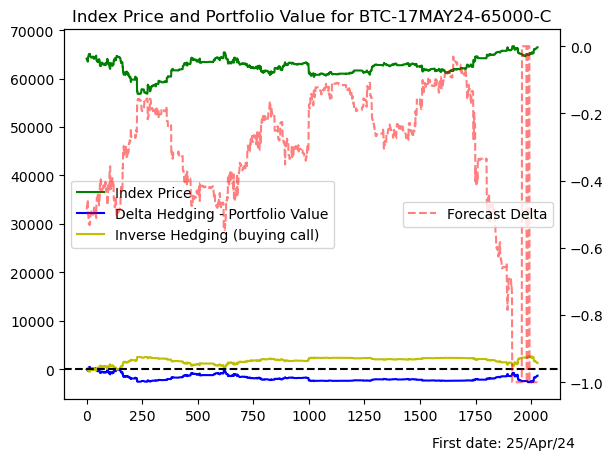

In [124]:
#Lets plot
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(results_4['index_price'], 'g-')
ax1.plot(results_4['portfolio_value'], 'b-')
ax1.plot(results_4['portfolio_value']*-1, 'y-')
#Lets put a line at 0
ax1.axhline(y=0, color='black', linestyle='--')
#We also add the stock position
ax2.plot(results_4['forecast_delta'], 'r--', alpha=0.5)
#lets add a title
plt.title('Index Price and Portfolio Value for BTC-17MAY24-65000-C')
#add the legend
ax1.legend(['Index Price', 'Delta Hedging - Portfolio Value','Inverse Hedging (buying call)'],loc = 'center left')
#Lets position the legend of the delta
ax2.legend(['Forecast Delta'],loc = 'center right') 
#Lets add a note at foot with the first date at format DD/BBB/YY like First date: 01/Jan/21
plt.figtext(0.7, 0.01, 'First date: ' + first_date_3.strftime('%d/%b/%y'))
plt.show()

In [96]:
#lets print
last_portfolio_value = results_4['portfolio_value'].iloc[-1]
print(f'Last Portfolio Value: {last_portfolio_value}')
#Lets also print the initial option value by black scholes
#print the initial option value
initial_option_value = black_scholes_call(df_btc_4['index_price'].iloc[0],df_btc_4['strike'].iloc[0],df_btc_4['time_to_maturity_year'].iloc[0],0,df_btc_4['iv'].iloc[0]/100)
print(f'Initial Option Value: {initial_option_value}')
print(f'Inverse Hedging (buying call): {results_4["portfolio_value"].iloc[-1]*-1}')

Last Portfolio Value: -1295.6137020849128
Initial Option Value: 3029.572782536008
Inverse Hedging (buying call): 1295.6137020849128


In [125]:
#Lets now check BTC-10MAY24-64000-C
df_btc_5 = df[df['instrument_name'] == 'BTC-10MAY24-64000-C']
results_5 = synthetic_delta_hedging(df_btc_5, 0, initial_stock_price=0)
#lets get first date
first_date_4 = df_btc_5['timestamp'].min()

/var/folders/tp/zh64fv6d1lx6rq42d6ymqtqw0000gn/T/ipykernel_13811/850695703.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))


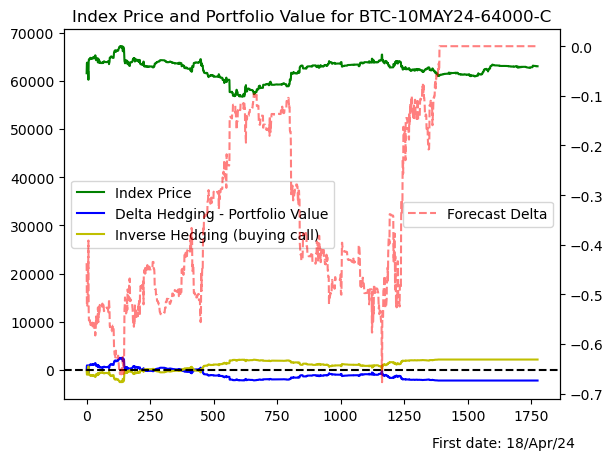

In [126]:
#Lets plot
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(results_5['index_price'], 'g-')
ax1.plot(results_5['portfolio_value'], 'b-')
ax1.plot(results_5['portfolio_value']*-1, 'y-')
#Lets put a line at 0
ax1.axhline(y=0, color='black', linestyle='--')
#We also add the stock position
ax2.plot(results_5['forecast_delta'], 'r--', alpha=0.5)
#lets add a title
plt.title('Index Price and Portfolio Value for BTC-10MAY24-64000-C')
#add the legend
ax1.legend(['Index Price', 'Delta Hedging - Portfolio Value','Inverse Hedging (buying call)'],loc = 'center left')
#Lets position the legend of the delta
ax2.legend(['Forecast Delta'],loc = 'center right')
#Lets add a note at foot with the first date at format DD/BBB/YY like First date: 01/Jan/21
plt.figtext(0.7, 0.01, 'First date: ' + first_date_4.strftime('%d/%b/%y'))
plt.show()


In [102]:
#lets print
last_portfolio_value = results_5['portfolio_value'].iloc[-1]
print(f'Last Portfolio Value: {last_portfolio_value}')
#Lets also print the initial option value by black scholes
#print the initial option value
initial_option_value = black_scholes_call(df_btc_5['index_price'].iloc[0],df_btc_5['strike'].iloc[0],df_btc_5['time_to_maturity_year'].iloc[0],0,df_btc_5['iv'].iloc[0]/100)
print(f'Initial Option Value: {initial_option_value}')
print(f'Inverse Hedging (buying call): {results_5["portfolio_value"].iloc[-1]*-1}')

Last Portfolio Value: -2177.0848032771037
Initial Option Value: 2954.2470508568804
Inverse Hedging (buying call): 2177.0848032771037


In [127]:
#Lets do the same for BTC-26APR24-80000-C 
df_btc_6 = df[df['instrument_name'] == 'BTC-26APR24-80000-C']
results_6 = synthetic_delta_hedging(df_btc_6, 0, initial_stock_price=0)
#lets get first date
first_date_5 = df_btc_6['timestamp'].min()


/var/folders/tp/zh64fv6d1lx6rq42d6ymqtqw0000gn/T/ipykernel_13811/850695703.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))


In [134]:
results_6.tail()

,timestamp,date,index_price,strike,days_to_maturity,forecast_iv,actual_iv,forecast_delta,delta_change,transaction_cost,portfolio_value,stock_position
2662,309453,2024-04-25,63375.95,80000.0,0,1.8454,1.8454,-0.0,0.0,0,-3999.651873,-0.0
2663,309454,2024-04-25,63375.95,80000.0,0,1.8454,1.8454,-0.0,0.0,0,-3999.651873,-0.0
2664,309455,2024-04-25,63375.95,80000.0,0,1.8454,1.8454,-0.0,0.0,0,-3999.651873,-0.0
2665,309456,2024-04-25,63375.95,80000.0,0,1.8454,1.8454,-0.0,0.0,0,-3999.651873,-0.0
2666,309457,2024-04-25,63375.95,80000.0,0,1.8454,1.8454,-0.0,0.0,0,-3999.651873,-0.0


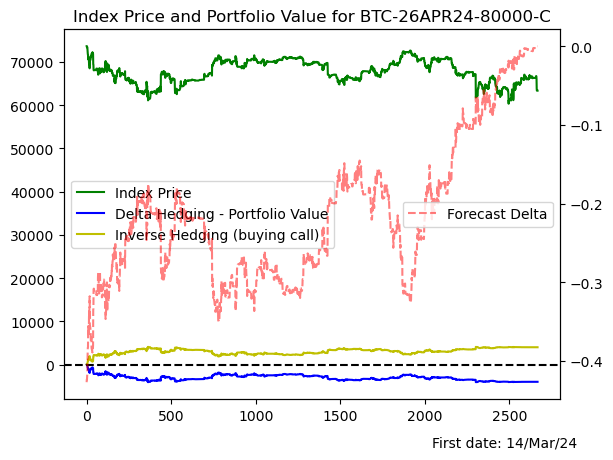

In [128]:
#lets plot
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(results_6['index_price'], 'g-')
ax1.plot(results_6['portfolio_value'], 'b-')
ax1.plot(results_6['portfolio_value']*-1, 'y-')
#Lets put a line at 0
ax1.axhline(y=0, color='black', linestyle='--')
#We also add the stock position
ax2.plot(results_6['forecast_delta'], 'r--', alpha=0.5)
#lets add a title
plt.title('Index Price and Portfolio Value for BTC-26APR24-80000-C')
#add the legend
ax1.legend(['Index Price', 'Delta Hedging - Portfolio Value','Inverse Hedging (buying call)'],loc = 'center left')
#Lets position the legend of the delta
ax2.legend(['Forecast Delta'],loc = 'center right')
#Lets add a note at foot with the first date at format DD/BBB/YY like First date: 01/Jan/21
plt.figtext(0.7, 0.01, 'First date: ' + first_date_5.strftime('%d/%b/%y'))
plt.show()

In [129]:
#lets print
last_portfolio_value = results_6['portfolio_value'].iloc[-1]
print(f'Last Portfolio Value: {last_portfolio_value}')
#Lets also print the initial option value by black scholes
#print the initial option value
initial_option_value = black_scholes_call(df_btc_6['index_price'].iloc[0],df_btc_6['strike'].iloc[0],df_btc_6['time_to_maturity_year'].iloc[0],0,df_btc_6['iv'].iloc[0]/100)
print(f'Initial Option Value: {initial_option_value}')
print(f'Inverse Hedging (buying call): {results_6["portfolio_value"].iloc[-1]*-1}')


Last Portfolio Value: -3999.6518734414135
Initial Option Value: 5225.479670300818
Inverse Hedging (buying call): 3999.6518734414135
